Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 4

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 60% accuracy (above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
import category_encoders as ce

In [0]:
# Merge train_features.csv & train_labels.csv
data = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [72]:
#train/validate split
train, val = train_test_split(data, random_state=63)

train.shape, val.shape, test.shape

((44550, 41), (14850, 41), (14358, 40))

In [73]:
#Define a function to wrangle train, validate, and test sets in the same way. 
#Clean outliers and engineer features.

def wrangle(X):
  """Wrangle train, validate, and test sets in the same way"""
    
  # Prevent SettingWithCopyWarning
  X = X.copy()
    
  # About 3% of the time, latitude has small values near zero,
  # outside Tanzania, so we'll treat these values like zero.
  X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
  # When columns have zeros and shouldn't, they are like null values.
  # So we will replace the zeros with nulls, and impute missing values later.
  #confirmed model is .2% worse when excluding population here
  cols_with_zeros = ['longitude', 'latitude','construction_year','population','gps_height']
  for col in cols_with_zeros:
      X[col] = X[col].replace(0, np.nan)
  
  #drop duplicate columns
  # quantity & quantity_group are duplicates, so drop one
  # payment == payment_type
  X = X.drop(columns=['quantity_group','payment_type'])
  
  # Drop recorded_by (never varies)
  unusable_variance = ['recorded_by']
  X = X.drop(columns=unusable_variance)
  
  #convert date_recorded to datetime
  X['date_recorded'] = X['date_recorded'].apply(pd.to_datetime)
  
  #drop the column but keep the information
  X['year_recorded'] = X['date_recorded'].dt.year
  X['month_recorded'] = X['date_recorded'].dt.month
  X['day_recorded'] = X['date_recorded'].dt.day
  X = X.drop(columns='date_recorded')
  
  #create 'age' column, the number of years between construction and evaluation
  X['age'] = X['year_recorded'] - X['construction_year']
  
  #bools for whether the waterpoint is marked as rural or urban
  #...make it a tiny bit worse
  X['rural'] = X['lga'].apply(lambda s: "Rural" in s)
  X['urban'] = X['lga'].apply(lambda s: "Urban" in s)
  
  #fill nans in latitude and longitude with averages for the region/basin
  #instead of relying on the simple imputer
  #using region makes the model worse by .3%
  #using basin makes it better by about the same amount!
  X2 = pd.DataFrame(columns=X.columns)

  for basin in X['basin'].value_counts().index:
    df = X[X['basin'] == basin]
    lat_mean = df['latitude'].mean()
    long_mean = df['longitude'].mean()
    df['latitude'] = df['latitude'].replace(np.nan,lat_mean)
    df['longitude'] = df['longitude'].replace(np.nan,long_mean)
    X2 = X2.append(df)
    
  #same thing for gps_height?
  #for either basin or region, seems to make it a little worse
  #concept: using the google elevation API to get elevation for those coordinates
  X3 = pd.DataFrame(columns=X.columns)

  for basin in X['region'].value_counts().index:
    df = X[X['region'] == basin]
    height_mean = df['gps_height'].mean()
    df['gps_height'] = df['gps_height'].replace(np.nan,height_mean)
    X3 = X3.append(df)
    
  # return the wrangled dataframe
  #return X
  return X3

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

#also make a wrangled version of all the training data to make an even better-fit
#model with which to predict for kaggle
data = wrangle(data)

train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,year_recorded,month_recorded,day_recorded,age,rural,urban
56788,50467,500.0,Adb,1763.0,DWE,34.856931,-9.045315,Anna Mdagachure,0,Rufiji,Kichiwa B,Iringa,11,4,Njombe,Igongolo,120.0,True,VWC,NaN,False,2009.0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,soft,good,enough,hand dtw,borehole,groundwater,hand pump,hand pump,functional,2011,2,21,2.0,False,False
27248,64186,0.0,Ba As,2172.0,Villa,34.646912,-9.628637,none,0,Lake Nyasa,Mkunga,Iringa,11,4,Njombe,Matola,50.0,True,VWC,Nyalik,False,2003.0,gravity,gravity,gravity,vwc,user-group,never pay,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,2011,2,26,8.0,False,False
34258,4423,1000.0,Rc Ch,2175.0,RC Ch,34.598252,-9.587432,none,0,Lake Nyasa,Ilala,Iringa,11,4,Njombe,Matola,20.0,True,VWC,Magang,False,2000.0,gravity,gravity,gravity,vwc,user-group,pay annually,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,2011,2,24,11.0,False,False
25325,18667,5000.0,Kkkt,2084.0,Commu,34.329664,-9.494521,none,0,Lake Nyasa,Matundu,Iringa,11,3,Makete,Ipepo,NaN,True,VWC,Ipepo,False,2003.0,gravity,gravity,gravity,vwc,user-group,pay annually,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,2011,3,5,8.0,False,False
54858,58479,500.0,Rcchurch/cefa,1573.0,RCchurch/CEFA,35.141129,-9.257869,Kwa Eugeni Msimike,0,Rufiji,Ukinga,Iringa,11,4,Njombe,Lupembe,150.0,True,WUA,matembwe water supply schem,True,1975.0,gravity,gravity,gravity,wua,user-group,pay monthly,soft,good,dry,river,river/lake,surface,communal standpipe,communal standpipe,non functional,2011,4,18,36.0,False,False


In [0]:
target = 'status_group'
features = train.columns.drop([target])

X_train = train[features]
y_train = train[target]

#oe = ce.OrdinalEncoder()
#y_train_encoded = oe.fit_transform(y_train)

X_val = val[features]
y_val = val[target]

X_data = data[features]
y_data = data[target]

X_test = test[features]

In [75]:
#pipeline includes:
#encoding of categorical variables as ordinal/numeric
#imputer for nans (median and mean are within .1% of each other in performance)
#random forest (many trees)
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=168, random_state=40, n_jobs=-1)
)

pipeline.fit(X_data, y_data)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 1.0


In [76]:
#making kaggle submission
y_pred = pipeline.predict(X_test)

y_pred

array(['functional', 'functional needs repair', 'non functional', ...,
       'functional', 'functional', 'functional'], dtype=object)

In [77]:
submission = pd.DataFrame(data={'id':test['id'],'status_group':y_pred})

submission.head()

,id,status_group
22,70970,functional
26,44718,functional needs repair
40,53540,non functional
46,50878,functional
50,59,non functional


In [0]:
submission.to_csv('fourth_submission.csv', index=False)
#I'm just gonna spend the rest of my time reading instead of trying to last-minute boost this

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

import seaborn as sns

In [21]:
y_pred = pipeline.predict(X_val)

#my work here is done!!
confusion_matrix(y_val, y_pred)
#nah let's make the pretty one

array([[7214,  163,  659],
       [ 594,  336,  165],
       [1300,   67, 4352]])

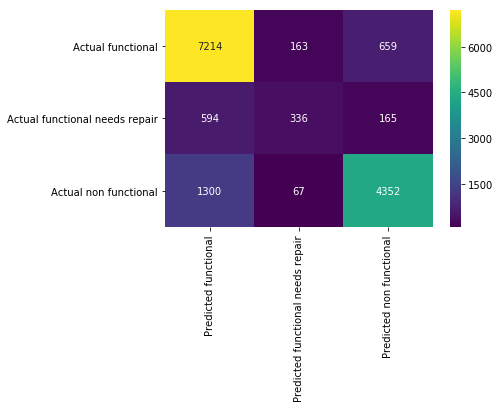

In [15]:
#code from lecture
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

plot_confusion_matrix(y_val, y_pred);

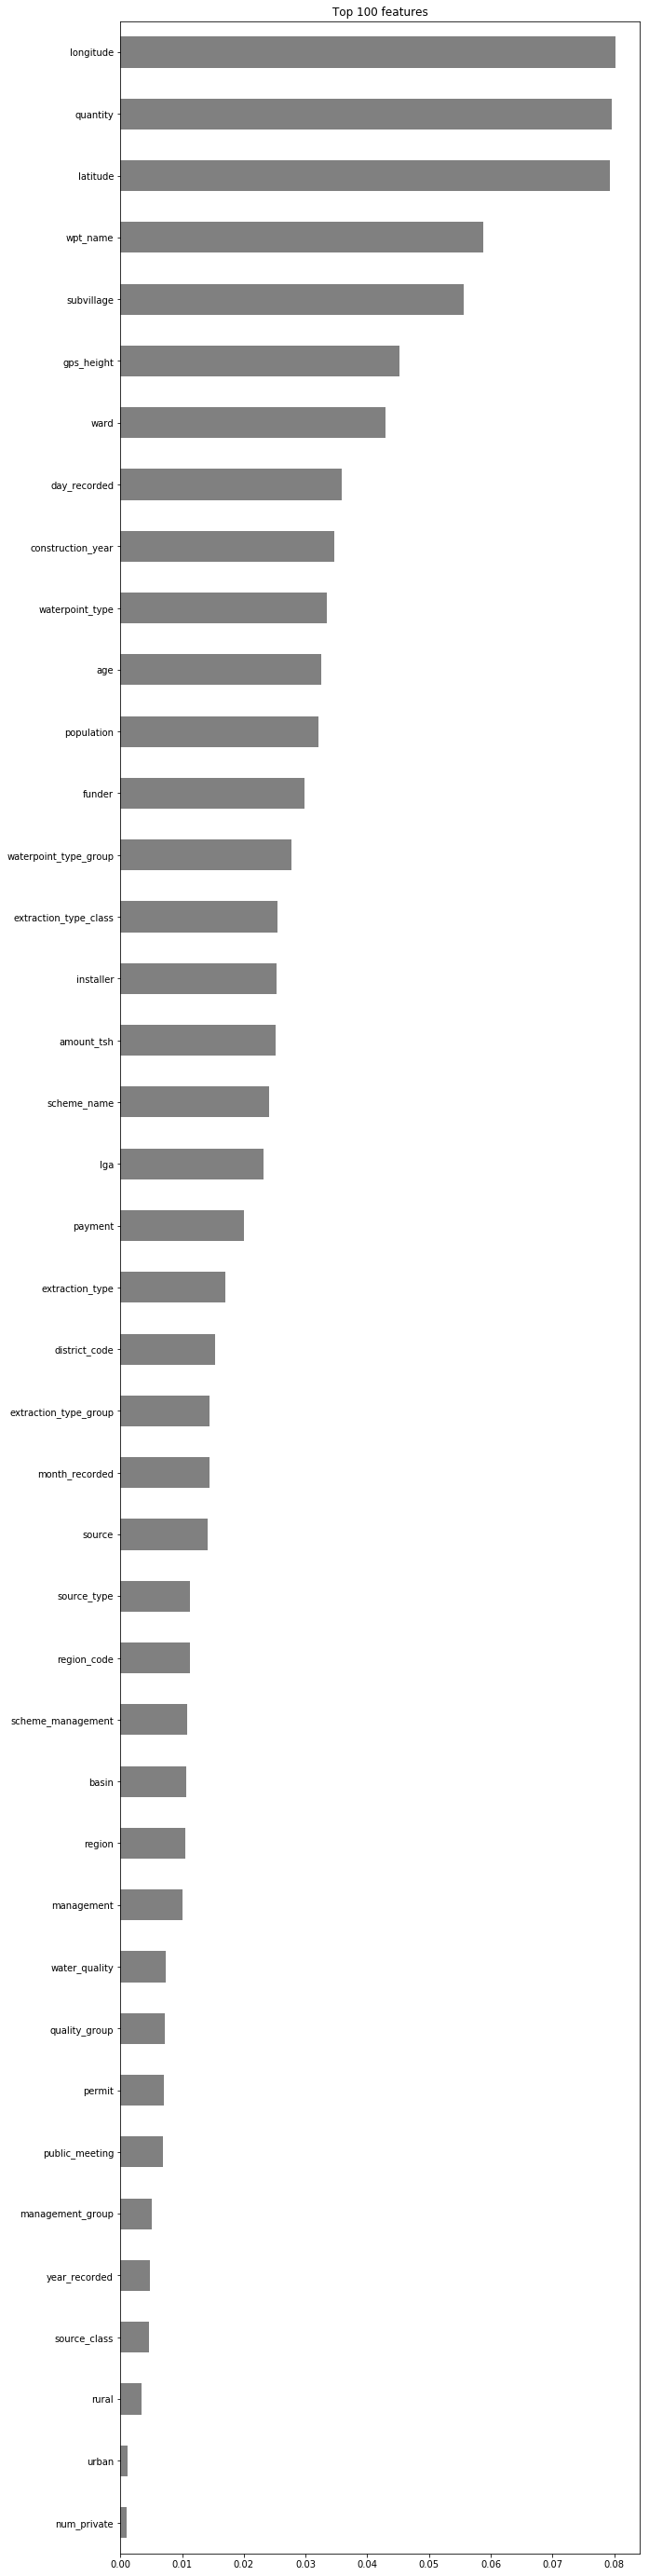

In [63]:
encoder = pipeline.named_steps['ordinalencoder']
encoded = encoder.transform(X_train)

# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)

# Plot feature importances
n = 100
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

In [56]:
pipeline2 = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    GradientBoostingClassifier()
)

pipeline2.fit(X_train, y_train)
print('Validation Accuracy', pipeline2.score(X_val, y_val))
#not as good!!!

Validation Accuracy 0.7489562289562289
